In [1]:
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import matplotlib.pyplot as plt
import mahotas
import cv2
import os
import h5py
from hydra import initialize, compose
from omegaconf import OmegaConf

with initialize(config_path="../config/"):
    data_cfg = compose(config_name="data_path")
data_cfg = OmegaConf.create(data_cfg)

HOME_PATH = "../"
DATA_PATH = data_cfg.data.leaf_tomato_disease_path
H5_TRAIN_DATA = data_cfg.data.h5_train_features
H5_LABEL_DATA = data_cfg.data.h5_train_labels

BINS = 8

h5_train_data = os.path.join(HOME_PATH, H5_TRAIN_DATA)
h5_label_data = os.path.join(HOME_PATH, H5_LABEL_DATA)

/home/nguyennam/anaconda3/envs/XLA/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: 
The version_base parameter is not specified.
Please specify a compatability version level, or None.
Will assume defaults for version 1.1
  if sys.path[0] == '':


In [2]:
def img_segmentation(rgb_img, hsv_img):
    lower_green = np.array([25,0,20])
    upper_green = np.array([100,255,255])
    

    healthy_mask = cv2.inRange(hsv_img, lower_green, upper_green)
    result = cv2.bitwise_and(rgb_img,rgb_img, mask=healthy_mask)

    lower_brown = np.array([10,0,10])
    upper_brown = np.array([30,255,255])
    disease_mask = cv2.inRange(hsv_img, lower_brown, upper_brown)
    disease_result = cv2.bitwise_and(rgb_img, rgb_img, mask=disease_mask)

    final_mask = healthy_mask + disease_mask
    final_result = cv2.bitwise_and(rgb_img, rgb_img, mask=final_mask)

    # fig = plt.figure(figsize=(20, 10))
    # (ax1, ax2), (ax3, ax4) = fig.subplots(2, 2)
    # ax1.imshow(rgb_img[:, :, ::-1])
    # ax2.imshow(result[:, :, ::-1])
    # ax3.imshow(disease_result[:,:, ::-1])
    # ax4.imshow(final_result[:,:, ::-1])
    # plt.show()

    return final_result

/home/nguyennam/Documents/20212/Xử lý ảnh/Project_XLA_2/src/utils.py:24: UserWarning: 
The version_base parameter is not specified.
Please specify a compatability version level, or None.
Will assume defaults for version 1.1
  with initialize(config_path="../config/"):


(256, 256)


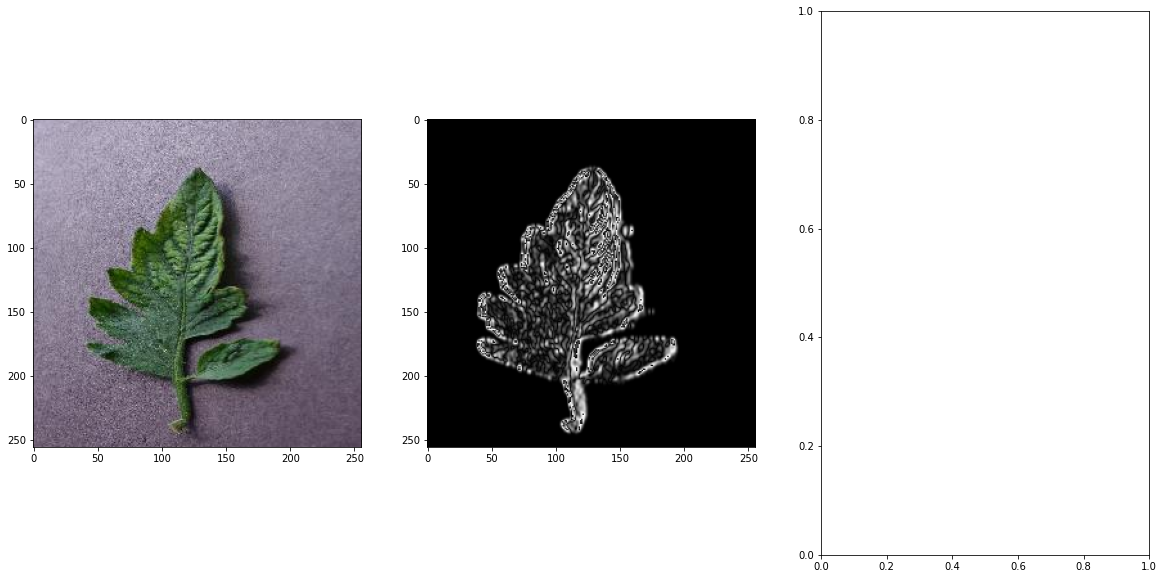

In [3]:
from utils import *

image = cv2.imread("../data/plantvillage/Tomato_mosaic_virus/000ec6ea-9063-4c33-8abe-d58ca8a88878___PSU_CG 2169.JPG")
rgb_img = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
hsv_img = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)

result = img_segmentation(rgb_img, hsv_img)
gray_img = cv2.cvtColor(result, cv2.COLOR_RGB2GRAY)

sobel_img = sobel_edge_detection_2(gray_img)

# kernel = np.ones((3,3),np.uint8)
# morphology = cv2.morphologyEx(sobel_img, cv2.MORPH_CLOSE, kernel)

print(sobel_img.shape)
fig = plt.figure(figsize=(20, 10))
ax1, ax2, ax3 = fig.subplots(1, 3)
ax1.imshow(image[:, :, ::-1])
ax2.imshow(sobel_img, cmap="gray")
# ax3.imshow(morphology, cmap="gray")
plt.show()



In [4]:
# feature-descriptor-1: Hu Moments
def fd_hu_moments(image):
    gray = np.copy(image)
    if len(image.shape) == 3: 
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    feature = cv2.HuMoments(cv2.moments(gray)).flatten()
    return feature

# feature-descriptor-2: Haralick Texture
def fd_haralick(image):
    gray = np.copy(image)
    if len(image.shape) == 3: 
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    haralick = mahotas.features.haralick(gray).mean(axis=0)
    return haralick

# feature-descriptor-3: Color Histogram
def fd_histogram(image, mask=None):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    hist  = cv2.calcHist([image], [0, 1, 2], None, [BINS, BINS, BINS], [0, 256, 0, 256, 0, 256])
    cv2.normalize(hist, hist)
    return hist.flatten() 

In [5]:
# get the training labels
train_labels = os.listdir(os.path.join(HOME_PATH, DATA_PATH))

# sort the training labels
train_labels.sort()
display(train_labels)

# empty lists to hold feature vectors and labels
global_features = []
labels = []

['Bacterial_spot',
 'Early_blight',
 'Healthy',
 'Late_blight',
 'Leaf_Mold',
 'Septoria_leaf_spot',
 'Spider_mites Two-spotted_spider_mite',
 'Target_Spot',
 'Tomato_Yellow_Leaf_Curl_Virus',
 'Tomato_mosaic_virus']

In [6]:
# import glob
# from tqdm import tqdm
# import gc

# train_path = "../data/plantvillage/"

# # loop over the training data sub-folders
# for training_name in train_labels:

#     file_names = glob.glob(f"{os.path.join(train_path, training_name)}/**")

#     # loop over the images in each sub-folder
#     for i, file in tqdm(enumerate(file_names), desc=f"[PROCESSING] folder: {training_name}"):
#         # read the image and resize it to a fixed-size
#         image = cv2.imread(file)

#         # Running Function Bit By Bit
#         RGB_BGR = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
#         BGR_HSV = cv2.cvtColor(RGB_BGR, cv2.COLOR_RGB2HSV)
#         IMG_SEGMENT = img_segmentation(RGB_BGR,BGR_HSV)

#         IMG_GRAY = cv2.cvtColor(result, cv2.COLOR_RGB2GRAY)

#         sobel_img = sobel_edge_detection_2(IMG_GRAY)
#         kernel = np.ones((3,3),np.uint8)
#         morphology_img = cv2.morphologyEx(sobel_img, cv2.MORPH_OPEN, kernel)
        
#         # Call for Global Fetaure Descriptors
#         fv_hu_moments = fd_hu_moments(morphology_img)
#         fv_haralick   = fd_haralick(morphology_img)
#         fv_histogram  = fd_histogram(IMG_SEGMENT)
        
#         # Concatenate 
#         global_feature = np.hstack([fv_histogram, fv_haralick, fv_hu_moments])
        
#         # update the list of labels and feature vectors
#         labels.append(training_name)
#         global_features.append(global_feature)

# print("[STATUS] completed Global Feature Extraction...")

[PROCESSING] folder: Bacterial_spot: 1702it [00:59, 28.38it/s]
[PROCESSING] folder: Early_blight: 800it [00:27, 28.61it/s]
[PROCESSING] folder: Healthy: 1273it [00:46, 27.66it/s]
[PROCESSING] folder: Late_blight: 1527it [00:55, 27.57it/s]
[PROCESSING] folder: Leaf_Mold: 761it [00:26, 28.21it/s]
[PROCESSING] folder: Septoria_leaf_spot: 1417it [00:51, 27.71it/s]
[PROCESSING] folder: Spider_mites Two-spotted_spider_mite: 1341it [00:50, 26.47it/s]
[PROCESSING] folder: Target_Spot: 1123it [00:42, 26.71it/s]
[PROCESSING] folder: Tomato_Yellow_Leaf_Curl_Virus: 4286it [02:36, 27.34it/s]
[PROCESSING] folder: Tomato_mosaic_virus: 299it [00:11, 27.04it/s]

[STATUS] completed Global Feature Extraction...


In [7]:
# # encode the target labels
# targetNames = np.unique(labels)
# le          = LabelEncoder()
# target      = le.fit_transform(labels)
# np.unique(target, return_counts=True)

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 array([1702,  800, 1273, 1527,  761, 1417, 1341, 1123, 4286,  299]))

In [8]:
# # scale features in the range (0-1)
# from sklearn.preprocessing import MinMaxScaler
# scaler            = MinMaxScaler(feature_range=(0, 1))
# rescaled_features = scaler.fit_transform(global_features)

In [9]:
# h5f_data = h5py.File(h5_train_data, 'w')
# h5f_data.create_dataset('dataset_1', data=rescaled_features)
# h5f_label = h5py.File(h5_label_data, 'w')
# h5f_label.create_dataset('dataset_1', data=target)

# h5f_data.close()
# h5f_label.close()

In [10]:
h5f_data  = h5py.File(h5_train_data, 'r')
h5f_label = h5py.File(h5_label_data, 'r')

global_features_string = h5f_data['dataset_1']
global_labels_string   = h5f_label['dataset_1']

global_features = np.array(global_features_string)
global_labels   = np.array(global_labels_string)

h5f_data.close()
h5f_label.close()

In [11]:
# split the training and testing data
from sklearn.model_selection import train_test_split
(X_train, X_test, y_train, y_test) = train_test_split(global_features, global_labels, test_size=0.2, random_state=10)

print("[STATUS] splitted train and test data...")
print("Train data  : {}".format(X_train.shape))
print("Test data   : {}".format(X_test.shape)) 

[STATUS] splitted train and test data...
Train data  : (11623, 532)
Test data   : (2906, 532)


In [12]:
# Oversampling
from imblearn.over_sampling import SMOTE
sm = SMOTE()
X_train_os, y_train_os = sm.fit_resample(X_train, y_train)

In [13]:
from utils import train_test_model

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis


classifiers = [
    KNeighborsClassifier(n_neighbors=10),
    DecisionTreeClassifier(random_state=42, max_depth=5),
    RandomForestClassifier(n_estimators=100, max_depth=5, random_state=9),
    SVC(kernel="linear", C=0.025),
    SVC(gamma=2, C=1),
    SVC(kernel='rbf'),
    MLPClassifier(alpha=1, max_iter=1000),
    GaussianNB(),
    QuadraticDiscriminantAnalysis(),
    AdaBoostClassifier(),
    GradientBoostingClassifier(n_estimators=100, learning_rate=1.0, max_depth=5),
    XGBClassifier(random_state=42, n_estimators=100),
]

In [14]:
_, _, best_model = train_test_model(classifiers, X_train, y_train, X_test, y_test)

TRAINING PROCESSING
KNeighborsClassifier
******  Results  *******
Accuracy: 0.8424 | Precision: 0.8130 | Recall: 0.8044 | F1 Score: 0.8036



/home/nguyennam/anaconda3/envs/XLA/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


DecisionTreeClassifier
******  Results  *******
Accuracy: 0.6156 | Precision: 0.5980 | Recall: 0.4733 | F1 Score: 0.4610



/home/nguyennam/anaconda3/envs/XLA/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


RandomForestClassifier
******  Results  *******
Accuracy: 0.7543 | Precision: 0.6841 | Recall: 0.6062 | F1 Score: 0.6051



/home/nguyennam/anaconda3/envs/XLA/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


SVC
******  Results  *******
Accuracy: 0.5747 | Precision: 0.5915 | Recall: 0.3917 | F1 Score: 0.3742

SVC
******  Results  *******
Accuracy: 0.8710 | Precision: 0.8539 | Recall: 0.8205 | F1 Score: 0.8344

SVC
******  Results  *******
Accuracy: 0.8310 | Precision: 0.8087 | Recall: 0.7518 | F1 Score: 0.7700



/home/nguyennam/anaconda3/envs/XLA/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


MLPClassifier
******  Results  *******
Accuracy: 0.6497 | Precision: 0.5023 | Recall: 0.4869 | F1 Score: 0.4751

GaussianNB
******  Results  *******
Accuracy: 0.5829 | Precision: 0.5642 | Recall: 0.6138 | F1 Score: 0.5421



/home/nguyennam/anaconda3/envs/XLA/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:878: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/nguyennam/anaconda3/envs/XLA/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


QuadraticDiscriminantAnalysis
******  Results  *******
Accuracy: 0.5795 | Precision: 0.5175 | Recall: 0.5563 | F1 Score: 0.5001

AdaBoostClassifier
******  Results  *******
Accuracy: 0.5396 | Precision: 0.4850 | Recall: 0.5235 | F1 Score: 0.4752

GradientBoostingClassifier
******  Results  *******
Accuracy: 0.8076 | Precision: 0.7675 | Recall: 0.7597 | F1 Score: 0.7613

XGBClassifier
******  Results  *******
Accuracy: 0.9566 | Precision: 0.9484 | Recall: 0.9436 | F1 Score: 0.9458



In [15]:
_, _, best_model = train_test_model(classifiers, X_train_os, y_train_os, X_test, y_test)

TRAINING PROCESSING
KNeighborsClassifier
******  Results  *******
Accuracy: 0.8438 | Precision: 0.7914 | Recall: 0.8351 | F1 Score: 0.8077

DecisionTreeClassifier
******  Results  *******
Accuracy: 0.5902 | Precision: 0.5768 | Recall: 0.5918 | F1 Score: 0.5709

RandomForestClassifier
******  Results  *******
Accuracy: 0.7760 | Precision: 0.7234 | Recall: 0.7815 | F1 Score: 0.7374

SVC
******  Results  *******
Accuracy: 0.6081 | Precision: 0.5831 | Recall: 0.6154 | F1 Score: 0.5490

SVC
******  Results  *******
Accuracy: 0.8937 | Precision: 0.8609 | Recall: 0.8798 | F1 Score: 0.8689

SVC
******  Results  *******
Accuracy: 0.8627 | Precision: 0.8166 | Recall: 0.8506 | F1 Score: 0.8307

MLPClassifier
******  Results  *******
Accuracy: 0.6545 | Precision: 0.5948 | Recall: 0.6466 | F1 Score: 0.5830

GaussianNB
******  Results  *******
Accuracy: 0.6029 | Precision: 0.5810 | Recall: 0.6302 | F1 Score: 0.5650



/home/nguyennam/anaconda3/envs/XLA/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:878: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


QuadraticDiscriminantAnalysis
******  Results  *******
Accuracy: 0.6387 | Precision: 0.6218 | Recall: 0.6647 | F1 Score: 0.6201

AdaBoostClassifier
******  Results  *******
Accuracy: 0.3259 | Precision: 0.2995 | Recall: 0.3847 | F1 Score: 0.2611

GradientBoostingClassifier
******  Results  *******
Accuracy: 0.9047 | Precision: 0.8915 | Recall: 0.8932 | F1 Score: 0.8918

XGBClassifier
******  Results  *******
Accuracy: 0.9587 | Precision: 0.9485 | Recall: 0.9516 | F1 Score: 0.9498



In [16]:
best_model

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, objective='multi:softprob',
              predictor='auto', random_state=42, reg_alpha=0, ...)